## < 참고 사항 >

1. simpson_trainset(20개 폴더, 41866개 파일)

   simpson_testset(20개 폴더, 990개 파일) 사용

2. simpson_trainset 으로 train, validation,

   simpson_testset으로 test set 설정

3. accuracy
 - train set: 92.77% 
 - test set: 70.10% 

4. 데이터 셋의 폴더 개수 차이가 나서 정확한 분석이 안될것 같아(연습1-2) trainset의 폴더 수와 testset의 폴더 수를 동일하게 맞춰서 진행


## 0. 구글 드라이브 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 이미지파일 데이트프레임으로 만들기

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def proc_img(filepath):
    """ 파일 경로와 그림의 레이블을 사용하여 DataFrame 만들기
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 파일 경로와 레이블 연결
    df = pd.concat([filepath, labels], axis=1)

    # DataFrame을 섞고 인덱스를 재설정
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# 파일 경로로 목록 만들기
train_dir = Path('/content/drive/MyDrive/Colab Notebooks/Simpson Project/simpson_trainset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/drive/MyDrive/Colab Notebooks/Simpson Project/simpson_testset')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))


# 파일 경로와 그림의 레이블을 사용하여 DataFrame 만들기
df = proc_img(filepaths)
df_test = proc_img(filepaths_test)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# 한 열에 파일 경로가 있고 다른 열에 레이블이 있는 DataFrame
df.head(5)

Number of pictures: 19548

Number of different labels: 20

Labels: ['charles_montgomery_burns' 'nelson_muntz' 'bart_simpson' 'lisa_simpson'
 'milhouse_van_houten' 'krusty_the_clown' 'moe_szyslak' 'edna_krabappel'
 'homer_simpson' 'chief_wiggum' 'ned_flanders' 'sideshow_bob'
 'apu_nahasapeemapetilon' 'mayor_quimby' 'marge_simpson'
 'principal_skinner' 'lenny_leonard' 'kent_brockman' 'comic_book_guy'
 'abraham_grampa_simpson']


,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/Simpson...,charles_montgomery_burns
1,/content/drive/MyDrive/Colab Notebooks/Simpson...,nelson_muntz
2,/content/drive/MyDrive/Colab Notebooks/Simpson...,bart_simpson
3,/content/drive/MyDrive/Colab Notebooks/Simpson...,lisa_simpson
4,/content/drive/MyDrive/Colab Notebooks/Simpson...,lisa_simpson


In [ ]:
print(f'Number of pictures: {df_test.shape[0]}\n')
print(f'Number of different labels: {len(df_test.Label.unique())}\n')
print(f'Labels: {df_test.Label.unique()}')
df_test.head(5)

Number of pictures: 990

Number of different labels: 20

Labels: ['lenny_leonard' 'lisa_simpson' 'edna_krabappel' 'nelson_muntz'
 'comic_book_guy' 'bart_simpson' 'moe_szyslak' 'apu_nahasapeemapetilon'
 'mayor_quimby' 'homer_simpson' 'charles_montgomery_burns'
 'abraham_grampa_simpson' 'milhouse_van_houten' 'marge_simpson'
 'kent_brockman' 'ned_flanders' 'chief_wiggum' 'principal_skinner'
 'sideshow_bob' 'krusty_the_clown']


,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/Simpson...,lenny_leonard
1,/content/drive/MyDrive/Colab Notebooks/Simpson...,lisa_simpson
2,/content/drive/MyDrive/Colab Notebooks/Simpson...,edna_krabappel
3,/content/drive/MyDrive/Colab Notebooks/Simpson...,nelson_muntz
4,/content/drive/MyDrive/Colab Notebooks/Simpson...,comic_book_guy


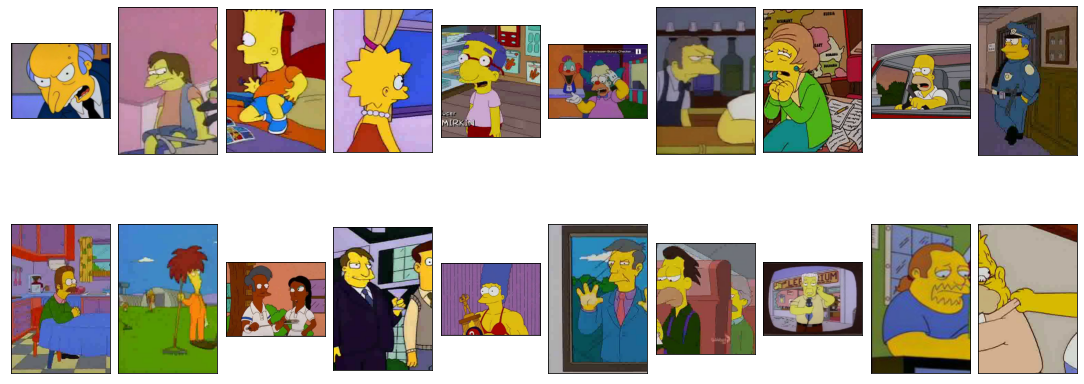

In [ ]:
# Train_ver
# 각 카테고리의 한 레이블이 있는 DataFrame 만들기
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# 데이터 세트의 40개 사진 표시
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    # ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

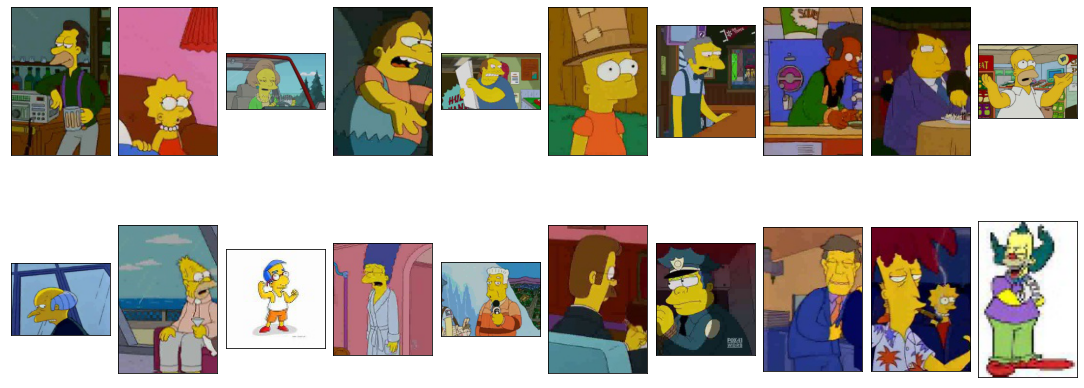

In [ ]:
# Test_ver
# 각 카테고리의 한 레이블이 있는 DataFrame 만들기
df_test_unique = df_test.copy().drop_duplicates(subset=["Label"]).reset_index()

# 데이터 세트의 40개 사진 표시
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test_unique.Filepath[i]))
    # ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

## 2. Generator 사용 

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15639 validated image filenames belonging to 20 classes.
Found 3909 validated image filenames belonging to 20 classes.
Found 990 validated image filenames belonging to 20 classes.


## 3. 모델 불러오기

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
489/489 [==============================] - 5812s 12s/step - loss: 1.6066 - accuracy: 0.5313 - val_loss: 1.0947 - val_accuracy: 0.6846
Epoch 2/50
489/489 [==============================] - 81s 166ms/step - loss: 0.9587 - accuracy: 0.7201 - val_loss: 1.0420 - val_accuracy: 0.6951
Epoch 3/50
489/489 [==============================] - 86s 176ms/step - loss: 0.7718 - accuracy: 0.7725 - val_loss: 0.9038 - val_accuracy: 0.7380
Epoch 4/50
489/489 [==============================] - 81s 165ms/step - loss: 0.6444 - accuracy: 0.8075 - val_loss: 0.8729 - val_accuracy: 0.7355
Epoch 5/50
489/489 [==============================] - 81s 166ms/step - loss: 0.5382 - accuracy: 0.8396 - val_loss: 0.8633 - val_accuracy: 0.7511
Epoch 6/50
489/489 [==============================] - 81s 166ms/step - loss: 0.4543 - accuracy: 0.8614 - val_loss: 0.8324 - val_accuracy: 0.7669
Epoch 7/50
489/489 [==============================] - 81s 165ms/step - loss: 0.3965 - accuracy: 0.8783 - val_loss: 0.8765 - val_ac

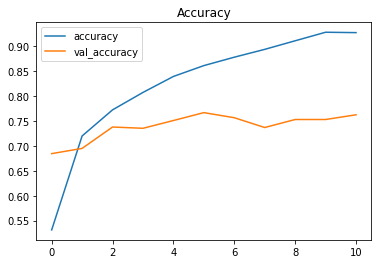

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

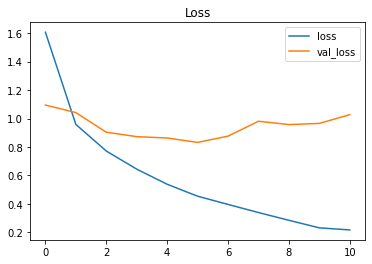

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## 4. 테스트 데이터 셋 예측

In [ ]:
# 테스트 이미지 예측
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# 레이블 매핑
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# 결과
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['moe_szyslak', 'lisa_simpson', 'homer_simpson', 'nelson_muntz', 'comic_book_guy']


In [ ]:
from sklearn.metrics import accuracy_score
y_test = list(df_test.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 70.10%


In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.91      0.42      0.57        48
  apu_nahasapeemapetilon       0.98      0.84      0.90        50
            bart_simpson       0.82      0.82      0.82        50
charles_montgomery_burns       0.68      0.67      0.67        48
            chief_wiggum       0.69      0.94      0.80        50
          comic_book_guy       0.96      0.47      0.63        49
          edna_krabappel       1.00      0.66      0.80        50
           homer_simpson       0.46      0.72      0.56        50
           kent_brockman       0.93      0.76      0.84        50
        krusty_the_clown       0.85      0.80      0.82        50
           lenny_leonard       0.96      0.50      0.66        50
            lisa_simpson       0.60      0.60      0.60        50
           marge_simpson       0.57      0.90      0.70        50
            mayor_quimby       0.84      0.62      0.71        50
     milh

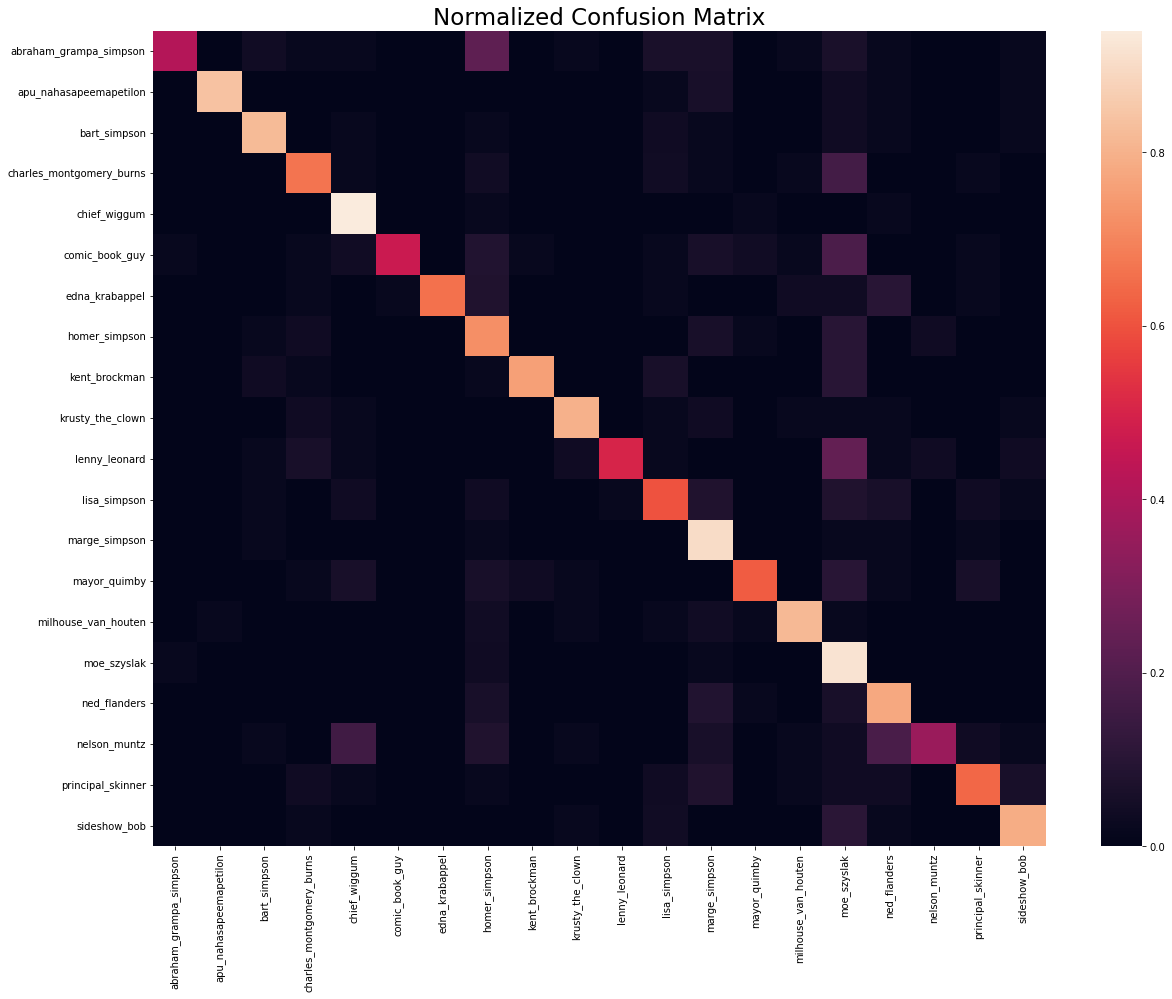

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

## 5. 결과 확인

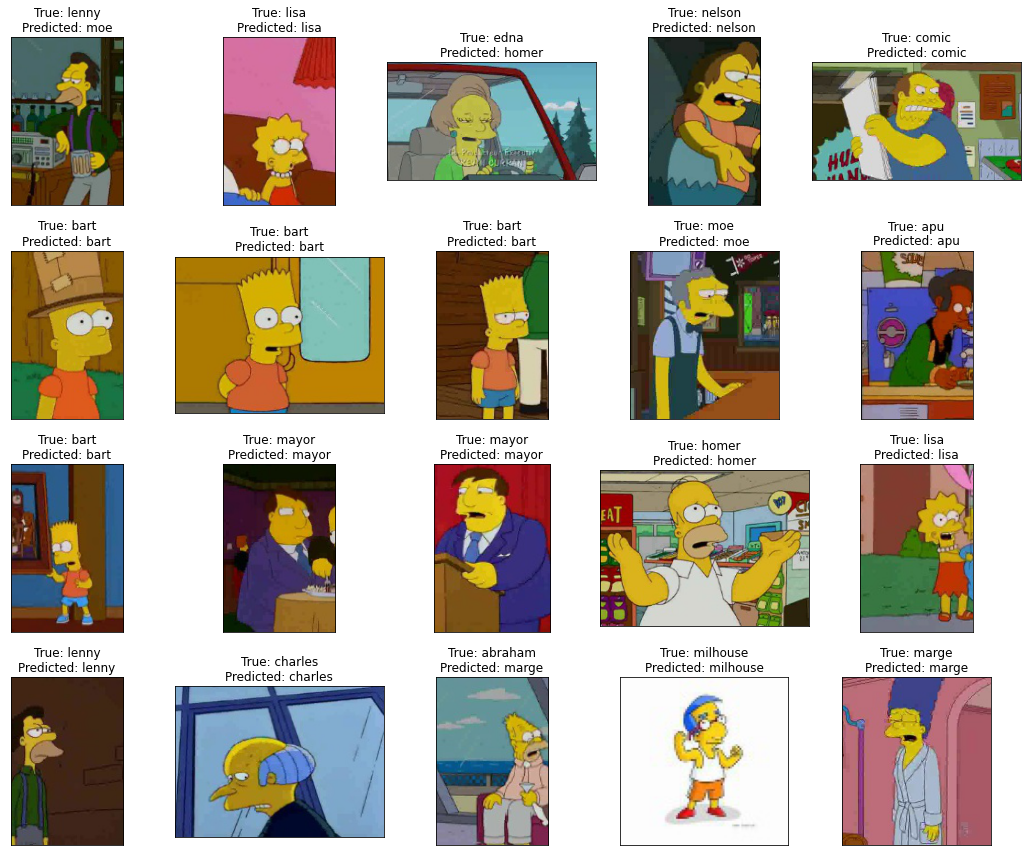

In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.Filepath.iloc[i]))
    ax.set_title(f"True: {df_test.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()